Скрипт для ранжирования отзывов по степени негативности. Ранжирование основано на классификация отзывов на позитивные и негативные и использует вероятность принадлежности отзыва к негативному классу.

In [ ]:
from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import nadam
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import softmax
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [4]:
df = pd.read_csv('data/range/train_data.csv')
df.loc[df["score"] == 'Негативный', 'score'] = 1
df.loc[df["score"] == 'Позитивный', 'score'] = 0

"""
Для повышения точности модели, к предикторам были добавлены заголовки отзывов.
"""

X,Y = ([x1+" "+x2 for (x1, x2) in zip(df['title'], df['text'])], df['score'])
df.head()

,Unnamed: 0,title,text,score
0,0,Просьба об отмене штрафа КАСКО,Здравствуйте! 10.06.2016г. мною был заключен д...,0
1,1,"В целом хорошо, работали по ипотеке.","Брала ипотеку в юникоре, порадовали квалифика...",1
2,2,Нас всегда выручает банк Уралсиб!,Знакомство с банком началось с ипотеки в 2009 ...,0
3,3,Абсолютно неприемлемая ситуация и ее решение,Клиент Совкомбанка с 2017 года. В феврале 2018...,0
4,4,Внёс не туда,Пришёл оплачивать кредит и ошибочно внёс деньг...,0


In [121]:
x_train = X[:9000]
x_test = X[9000:]
y_train = Y[:9000]
y_test = Y[9000:]

Наилучшие результаты получились на данных, обработанных TF-IDF векторайзером без предварительной предобработки.

In [122]:
tv = TfidfVectorizer()
tv.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [123]:
import pickle
with open('tvr.pickle', 'wb') as f:
    """Сохраняем токинайзер"""
    pickle.dump(tv, f)

In [ ]:
X_train = tv.transform(x_train)
X_test = tv.transform(x_test)

onehot = OneHotEncoder(sparse=False)

Y_test = np.reshape(np.array(y_test), (-1,1))
Y_test =onehot.fit_transform(Y_test)

Y_train = np.reshape(np.array(y_train), (-1,1))
Y_train =onehot.fit_transform(Y_train)

Определяем модель. Многослойный перцептрон показал наилучший результат из всех опробованных моделей.

In [145]:
input_shape = np.shape(X_train)[1]

model = Sequential()

model.add(Dense(4, input_shape=(input_shape,)))
model.add(LeakyReLU())
model.add(Dropout(0.6))

model.add(Dense(4, kernel_regularizer=l2(0.05)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [146]:
checkpointer = ModelCheckpoint(filepath="weight.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
opt=nadam(lr=0.00009)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, verbose=1, callbacks=[checkpointer])

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

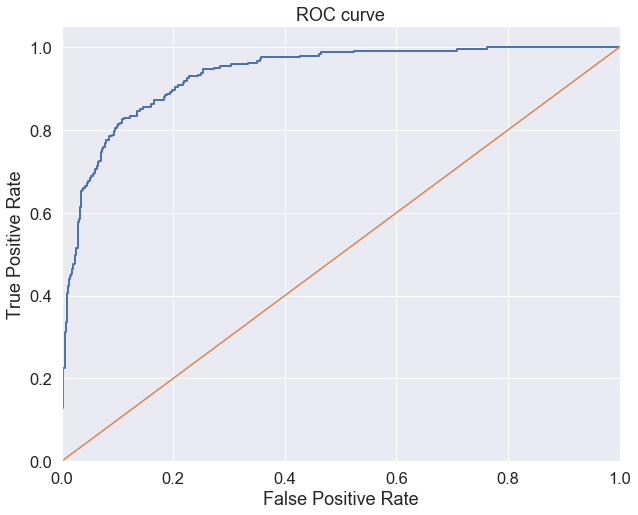

0.933517021195174


In [137]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_curve, roc_auc_score,auc
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()
print(roc_auc_score(y_test, model.predict(X_test)[:,1]))

Загружаем тестовую выборку и делаем предсказания

In [117]:
df_test = pd.read_csv('data/range/test_data.csv')
x_test = [x1+" "+x2 for (x1, x2) in zip(df_test['title'], df_test['text'])]

In [118]:
X_test = tv.transform(x_test)
predicts = model.predict(X_test)[:,1]

In [119]:
sub = pd.DataFrame({'index': range(0, len(predicts)),
                    'score':predicts})
sub.to_csv('ranking_answer.csv', index=False)